
### Import libraries and modules

In [10]:
import copy
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import create_inputsTable_UTOPIA
from functions.create_rateConstants_tabel import *
from functions.fillInteractions_df_fun import *
from functions.generate_modelObjects import *
from functions.generateRateConstants_particles import *
from functions.solver_SteadyState import *
from functions.extract_results import *
from functions.plot_results import *
from functions.massBalance import *
from functions.fill_interactions_Knames import *
from functions.exposure_indicators_calculation import *
from functions.generate_MPinputs_table import *
from functions.save_results import *
from model_run import *
from functions.loop_CTD_calculation import *

Set up path for inputs folder

In [22]:
##Set current working directory
cwd=os.getcwd()
inputs_path = cwd+"\inputs"
inputs_path

'c:\\Users\\PradoDomercq\\Documents\\Python Scripts\\UTOPIA_model\\inputs'

### Define run parameters

#### Define microplastics physical properties

In [6]:
MPdensity_kg_m3 = 1580
MP_composition = "PVC"
shape = "sphere"  # Fixed for now
N_sizeBins = 5  # Fixed, should not be changed. The 5 size bins are generated as being one order of magnitude appart and cover the range from mm to nm(i.e. 5000um, 500um, 50um, 5um, 0.5um)
big_bin_diameter_um = 5000  # This size can not be bigger than 10 mm (10000um) or smaller than 1 mm(1000um)
runName = MP_composition


In [17]:
# write microplastics inputs file
mp_imputFile_name = write_MPinputs_table(
    MPdensity_kg_m3,
    MP_composition,
    shape,
    N_sizeBins,
    big_bin_diameter_um,
    runName,
    inputs_path,
)

'c:\\Users\\PradoDomercq\\Documents\\Python Scripts\\UTOPIA_model\\inputs\\inputs_microplasticsPVC.csv'

#### Define Environmental Characteristics

##### Suspended particulates properties

In [19]:
# From Kooi et al. (2017)
v_a = 2.0e-16  # Volume of 1 algal cell [m-3]
r_a = ((3.0 / 4.0) * (v_a / math.pi)) ** (1.0 / 3.0)  # radius of algae [m]

spm_radius_um = r_a * 1e6
spm_density_kg_m3 = 1388  # REF: Kooi et al. (2017)

##### Compartment properties

In [20]:
comp_impFile_name = "\inputs_compartments.csv"  # Preloaded values, the user should be able to create its own inputs_compartments.csv file (via donwloading the file and typing news values without chaing the structure of the file) when a new file wants to be used the name should be changed here
comp_interactFile_name = (
    "\compartment_interactions.csv"  # Fixed, should not be modified
)

##### Generate model objects (via reading selected input files)

In [24]:
# Generate objects
boxName = "Utopia"  # fixed, do not modify

(
    system_particle_object_list,
    SpeciesList,
    spm,
    dict_comp,
    model_lists,
    particles_df,
) = generate_objects(
    inputs_path,
    boxName=boxName,
    MPforms_list=MPforms_list,
    comp_impFile_name=comp_impFile_name,
    comp_interactFile_name=comp_interactFile_name,
    mp_imputFile_name=mp_imputFile_name,
    spm_radius_um=spm_radius_um,
    spm_density_kg_m3=spm_density_kg_m3,
)

surfComp_list = [c for c in dict_comp if "Surface" in c]

#### Define Microplastics weathering properties


##### Select fragmentation style
In out approach each particle fractions into fragments of smaller sizes and the distribution is expresses via a fragment size distribution matrix (fsd), as desciber in https://microplastics-cluster.github.io/fragment-mnp/advanced-usage/fragment-size-distribution.html .  

In this matrix the smallest size fraction is in the first possition and we consider no fragmentation for this size class 

Below we define 4 different styles of fragmentation via defininf the fsd for each of them. The user can choose form one of the proposed fragmentation styles or define its own fsd by including it in the frag_styles_dict following the structure below.

In [37]:
if N_sizeBins == 5:
    frag_styles_dict = {
        "sequential_fragmentation": np.array(
            [
                [0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 1, 0],
            ]
        ),
        "erosive_fragmentation": np.array(
            [
                [0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [0.99, 0.01, 0, 0, 0],
                [0.999, 0, 0.001, 0, 0],
                [0.9999, 0, 0, 0.0001, 0],
            ]
        ),
        "mixed_fragmentation": np.array(
            [
                [0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [0.5, 0.5, 0, 0, 0],
                [0.6, 0.2, 0.2, 0, 0],
                [0.7, 0.15, 0.1, 0.05, 0],
            ]
        ),
        "no_fragmentation": np.array(
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ]
        ),
    }

    
else:
    print(
        "Fragmetation size distribution not defined for this number of size fractions, please define manually the fsd matrix via the fsd.csv file"
    )
    fsd_df = pd.read_csv(os.path.join(inputs_path, "fsd.csv"), index_col=0)
    fsd = fsd_df.to_numpy()


In [38]:
frag_style = "mixed_fragmentation"


In [39]:

fsd = frag_styles_dict[frag_style]
sizes = [list(model_lists["dict_size_coding"].keys())]
fsd_df = pd.DataFrame(fsd, index=sizes, columns=sizes)

# Save the fsd matrix
fsd_filename = os.path.join(inputs_path, "fsd.csv")
fsd_df.to_csv(fsd_filename)

##### Define Weathering processes input parameters

##### Degradation half time: thalf_deg_d

The model provides default values for degradation times taken from Domercq et al. 2021 in the file (t_half_deg.csv):
 
The assumptions made for the definition of these degradation times: 
    - Heteroaggregated particles degrade 10 times slower than the free MPs
    - Biofouled particles degrade 5 times slower than the free MPs

If the user want to provide its own values of thalf_deg_d the values can be modified in the following dictionary and running the following code by chaging the cell to code

thalf_deg_d_dict = {
     "freeMP": 5000,
     "heterMP": 50000,
     "biofMP": 25000,
     "heterBiofMP": 100000,
 } 

t_half_deg_filename = os.path.join(inputs_path, "t_half_deg.csv")
t_half_deg_df = pd.DataFrame(list(thalf_deg_d_dict.items()), columns=['MP_form', 'thalf_deg_d'])
t_half_deg_df.to_csv(t_half_deg_filename,index=False)


In [40]:
# Read the CSV file into a DataFrame
t_half_deg_filename = os.path.join(inputs_path, "t_half_deg.csv")
t_half_deg_df = pd.read_csv(t_half_deg_filename)

# Convert the DataFrame to a dictionary
thalf_deg_d_dict = t_half_deg_df.set_index("MP_form")["thalf_deg_d"].to_dict()

#### Heteroaggregation attachment efficiency: alpha_heter.

In [32]:
alpha_heter_filename = os.path.join(inputs_path, "alpha_heter.csv")
alpha_heter_df = pd.read_csv(alpha_heter_filename)
alpha_hetr_dict = alpha_heter_df.set_index("MP_form")["alpha_heter"].to_dict()

#### Timescales of fragmentation

The fragmentation timescales are deteremined from the an stablished fragmentation half time of 36.5 days for the biggets size fraction in free form in the surface water compartments following the parameters chosen in Domercq et al. 2021.

In UTOPIA we include fragmentation of the heteroaggregated MPs as being 100 slower than fragmentation of the Free MPs and breackup of biofouled and heteroaggregated will be two times slowed of those only heteroaggregated, following the same assumption as for free and biofouled. These values are used in the Domercq et al. 2021 paper and they are asumptions made from lack of current knowlegde

In [33]:
t_frag_gen_FreeSurfaceWater = 36.5  # in days

In [36]:
process_inputs_df = create_inputsTable_UTOPIA(
    inputs_path,
    model_lists,
    thalf_deg_d_dict,
    alpha_hetr_dict,
    t_frag_gen_FreeSurfaceWater,
)

#### Define emission scenario

Choose input flow (in g per second) and define in wich form and size the particles are released into the environment and specify the input flow for each compartment

In [41]:
# Size fraction:
# for the preloaded scenario:
# a= 0.5 um
# b= 5 um
# c= 50 um
# d= 500 um
# e= 5000 um
import string

size_codes = [letter for letter in string.ascii_lowercase[0:N_sizeBins]]
size_dict = dict(zip(size_codes, model_lists["dict_size_coding"].values()))

# Aggregation state (MP form):
# A= Free MP
# B= heteroaggregatedMP
# C= biofouled MP
# D= biofouled and heteroaggregated MP
MPforms_list = ["freeMP", "heterMP", "biofMP", "heterBiofMP"]
particle_forms_coding = dict(zip(MPforms_list, ["A", "B", "C", "D"]))
MP_form_dict_reverse = {v: k for k, v in particle_forms_coding.items()}

##### Select size bin and form

In [42]:
size_bin = "e"  # Chosse from size_dict
MP_form = "freeMP"  # Choose from MPforms_list above

##### Type input flow in g/s

If inputs are only made to one compartment:

In [43]:
emiss_comp = "Coast_Surface_Water"  # Select compartment from the compartment list
input_flow_g_s = 1  # Choose input flow (in g per second)

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

q_mass_g_s_dict[emiss_comp] = input_flow_g_s

If emissions are made to several compartments type the input flows corresponding to the specific compartments in the following dictionary:

q_mass_g_s_dict = {
    "Ocean_Surface_Water": 0,
    "Ocean_Mixed_Water": 0,
    "Ocean_Column_Water": 0,
    "Coast_Surface_Water": 0,
    "Coast_Column_Water": 0,
    "Surface_Freshwater": 0,
    "Bulk_Freshwater": 0,
    "Sediment_Freshwater": 0,
    "Sediment_Ocean": 0,
    "Sediment_Coast": 0,
    "Urban_Soil_Surface": 0,
    "Urban_Soil": 0,
    "Background_Soil_Surface": 0,
    "Background_Soil": 0,
    "Agricultural_Soil_Surface": 0,
    "Agricultural_Soil": 0,
    "Air": 0,
}

In [44]:
input_flow_filename = os.path.join(inputs_path, "inputFlows.csv")
input_flows_df = pd.DataFrame(
    list(q_mass_g_s_dict.items()), columns=["compartment", "q_mass_g_s"]
)
input_flows_df.to_csv(input_flow_filename, index=False)

## Model Run Summary

In [46]:
saveName = (
    MP_composition
    + "_MP_Emissions_"
    + MP_form
    + "_"
    + str(size_dict[size_bin])
    + "_nm_"
    + frag_style
)

# Print model run summary

print("Model run: ")
print("Emissions flow (g/s): ", input_flow_g_s)
desired_key = next(key for key, value in q_mass_g_s_dict.items() if value > 0)
print("Receiving compartment/s: ", desired_key)
print("Emitted MP density (kg/m3): ", MPdensity_kg_m3)
print("Emitted MP shape: ", shape)
print("Emitted MP form: ", MP_form)
print("Emitted MP size (um): ", size_dict[size_bin])
print("Selected fragmentation style: ", frag_style)


Model run: 
Emissions flow (g/s):  1
Receiving compartment/s:  Coast_Surface_Water
Emitted MP density (kg/m3):  1580
Emitted MP shape:  sphere
Emitted MP form:  freeMP
Emitted MP size (um):  5000.0
Selected fragmentation style:  mixed_fragmentation


### Run Model

In [47]:
"""Estimate rate constants per particle"""

for particle in system_particle_object_list:
    generate_rateConstants(particle, spm, dict_comp, fsd)


## create rate constants table:
RC_df = create_rateConstants_table(system_particle_object_list)
df4 = RC_df.fillna(0)

"""Build Matrix of interactions"""

interactions_df = fillInteractions_fun_OOP(
    system_particle_object_list, SpeciesList, surfComp_list
)


"""SOLVE SYSTEM OF ODES"""

particle_compartmentCoding = dict(
    zip(
        model_lists["compartmentNames_list"],
        list(range(len(model_lists["compartmentNames_list"]))),
    )
)
comp_dict_inverse = {v: k for k, v in particle_compartmentCoding.items()}

sp_imputs = []
q_mass_g_s = []
for compartment in q_mass_g_s_dict.keys():

    sp_imputs.append(
        size_bin
        + particle_forms_coding[MP_form]
        + str(particle_compartmentCoding[compartment])
        + "_"
        + boxName
    )
    q_mass_g_s.append(q_mass_g_s_dict[compartment])

imput_flows_g_s = dict(zip(sp_imputs, q_mass_g_s))

q_num_s = [
    mass_to_num(v, p.Pvolume_m3, p.Pdensity_kg_m3) if v != 0 else 0
    for k, v in zip(imput_flows_g_s.keys(), imput_flows_g_s.values())
    for p in system_particle_object_list
    if k == p.Pcode
]

# imput_flows_num_s = dict(zip(sp_imputs, q_num_s))


R, PartMass_t0 = solve_ODES_SS(
    system_particle_object_list=system_particle_object_list,
    q_num_s=0,
    imput_flows_g_s=imput_flows_g_s,
    interactions_df=interactions_df,
)

# Reformat results (R) dataframe
R["Size_Fraction_um"] = [size_dict[x[0]] for x in R.index]
R["MP_Form"] = [MP_form_dict_reverse[x[1]] for x in R.index]
R["Compartment"] = [comp_dict_inverse[float(x[2:-7])] for x in R.index]

Results = R[
    [
        "Compartment",
        "MP_Form",
        "Size_Fraction_um",
        "mass_g",
        "number_of_particles",
        "concentration_g_m3",
        "concentration_num_m3",
    ]
]

# Solve mass balance and print result
massBalance(R, system_particle_object_list, q_mass_g_s)


# Test that there are no negative results
for i, idx in zip(R["mass_g"], R.index):
    if i < 0:
        print("negative values in the solution for " + idx)
    else:
        pass

# Estimate mass and number fractions and extract ranking tables of the species with higest fractions to understand the distribution of the particles in the system by mass and number of particles

Results_extended, mf_shorted, nf_shorted = estimate_fractions(Results)

# Organise results in dictionary for plotting

Results_comp_dict = extract_by_comp(
    Results_extended.reset_index(), particle_compartmentCoding
)
Results_comp_organiced = extract_by_aggSt(Results_comp_dict, particle_forms_coding)

# Mass distribution by compartment
mass_frac_100 = []
num_frac_100 = []
mass_conc_g_m3 = []
num_conc = []
for comp in list(dict_comp.keys()):
    mass_frac_100.append(
        sum(Results_extended[Results_extended["Compartment"] == comp]["mass_fraction"])
        * 100
    )
    num_frac_100.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp]["number_fraction"]
        )
        * 100
    )
    mass_conc_g_m3.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp][
                "concentration_g_m3"
            ]
        )
    )
    num_conc.append(
        sum(
            Results_extended[Results_extended["Compartment"] == comp][
                "concentration_num_m3"
            ]
        )
    )

mass_dist_comp = pd.DataFrame(columns=["Compartments"])
mass_dist_comp["Compartments"] = list(dict_comp.keys())
mass_dist_comp["%_mass"] = mass_frac_100
mass_dist_comp["%_number"] = num_frac_100
mass_dist_comp["Concentration_g_m3"] = mass_conc_g_m3
mass_dist_comp["Concentration_num_m3"] = num_conc

### MASS BALANCE PER COMPARTMENT###

# Estimate mass flows due to the different particle fate process (transfer between compartments, elimination and transformation processes)

from functions.generate_compartmentFlows_tables import *

# Estimate outflows in mass (g/s) amd number/second
(tables_outputFlows, tables_outputFlows_number) = estimate_outFlows(
    system_particle_object_list, dict_comp
)


# Estimate imput flows from transport from other compartments
(tables_inputFlows, tables_inputFlows_num) = estimate_inFlows(
    tables_outputFlows, tables_outputFlows_number, dict_comp, surfComp_list
)


## Compartment mass balance

comp_mass_balance = {}
for comp in list(dict_comp.keys()):
    comp_mass_balance[comp] = compartment_massBalance(
        comp=comp,
        tables_outputFlows=tables_outputFlows,
        PartMass_t0=PartMass_t0,
        comp_dict_inverse=comp_dict_inverse,
        dict_comp=dict_comp,
        tables_inputFlows=tables_inputFlows,
    )

# Print compartment mass balance table
comp_mass_balance_df = pd.DataFrame.from_dict(comp_mass_balance, orient="index")
print(comp_mass_balance_df)

comp_mass_balance_df["Mass balance"] = [
    comp_mass_balance_df["Inflow"][c] - comp_mass_balance_df["Outflow"][c]
    for c in comp_mass_balance_df.index
]

# Add total steady state mass and number of particles concentrations to dataframe

# comp_mass_balance_df["Total Mass (g)"] = [sum(Results_comp_dict[c].mass_g) for c in comp_mass_balance_df.index]
# comp_mass_balance_df["Total Number of Particles"] = [sum(Results_comp_dict[c].number_of_particles) for c in comp_mass_balance_df.index]
comp_mass_balance_df["Concentration (g/m3)"] = [
    sum(Results_comp_dict[c].concentration_g_m3) for c in comp_mass_balance_df.index
]
comp_mass_balance_df["Concentration (N/m3)"] = [
    sum(Results_comp_dict[c].concentration_num_m3) for c in comp_mass_balance_df.index
]


Difference inflow-outflow = -1.3322676295501878e-15
                                 Inflow       Outflow
Ocean_Surface_Water        3.643874e+00  3.643874e+00
Ocean_Mixed_Water          3.648089e+00  3.648089e+00
Ocean_Column_Water         4.812984e-03  4.812984e-03
Coast_Surface_Water        4.499357e+00  4.499336e+00
Coast_Column_Water         4.584591e+00  4.584591e+00
Surface_Freshwater         3.031559e-03  3.031559e-03
Bulk_Freshwater            3.033526e-03  3.033526e-03
Sediment_Freshwater        7.511246e-06  7.511246e-06
Sediment_Ocean             4.723967e-03  4.723967e-03
Sediment_Coast             1.081028e+00  1.081028e+00
Urban_Soil_Surface         1.354236e-07  7.927273e-09
Urban_Soil                 1.274963e-07  1.587809e-08
Background_Soil_Surface    1.173450e-04  6.928287e-06
Background_Soil            1.104167e-04  1.423132e-05
Agricultural_Soil_Surface  4.350546e-09  8.224960e-10
Agricultural_Soil          3.528050e-09  4.313097e-10
Air                        2.4

### Mass and number distribution heatmaps

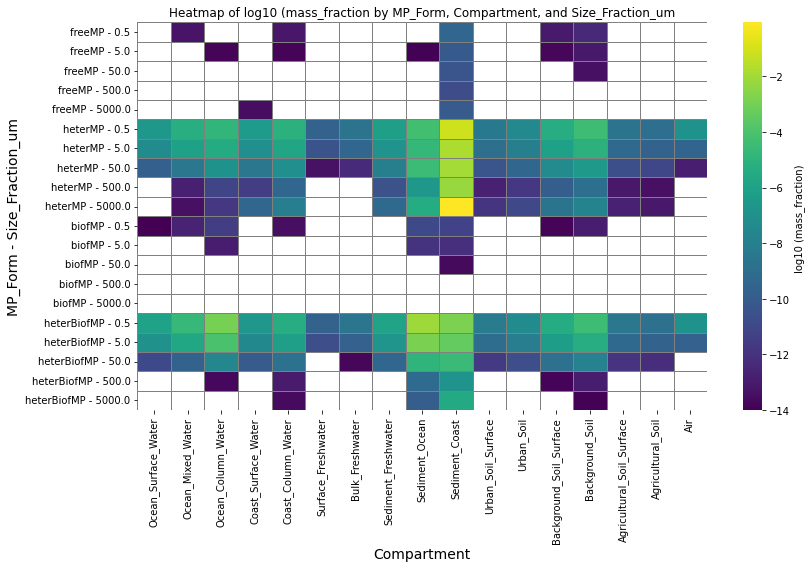

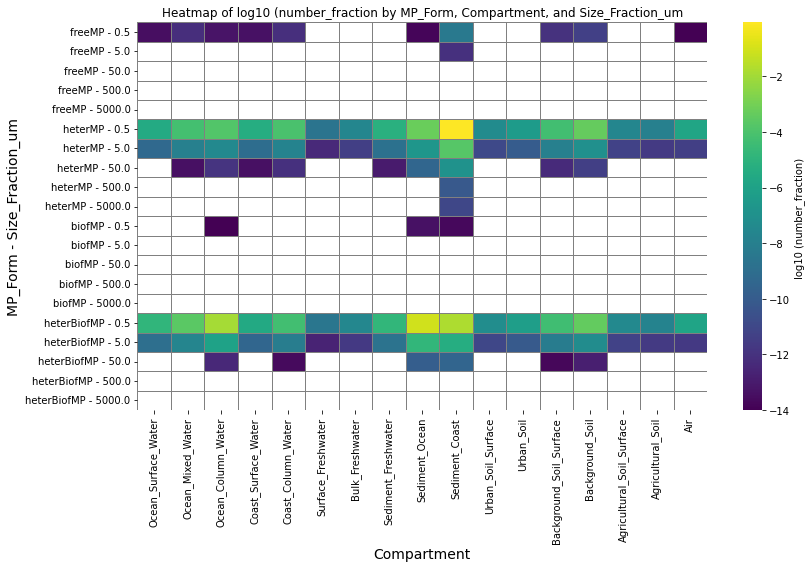

In [48]:
plot_fractionDistribution_heatmap(Results_extended, fraction="mass_fraction")
plot_fractionDistribution_heatmap(Results_extended, fraction="number_fraction")

### Exposure indicators

Environmentally Dispersed Mass Fractions through Air = 6.752941846754013e-07
Environmentally Dispersed Mass Fractions through Ocean_Mixed_Water = 2.0547103799111405e-07
Environmentally Dispersed Mass Fractions through Ocean_Surface_Water = 6.16335979143662e-10
φ1 for mass = 8.81381558645659e-07
Environmentally Dispersed Particle Number Fractions through Air = 673972
Environmentally Dispersed Particle Number Fractions through Ocean_Mixed_Water = 186041
Environmentally Dispersed Particle Number Fractions through Ocean_Surface_Water = 558
φ1 for particle number = 860572.4855788788
Remotely transferred fraction to Ocean_Surface_Water = 4.364210723277493e-14
Remotely transferred fraction to Ocean_Column_Water = 3.667172538754485e-11
Remotely transferred fraction to Sediment_Ocean = 1.6065023728751502e-07
Remotely transferred fraction to Background_Soil_Surface = 1.997529925440994e-08
Total remotely transferred mass fraction = 1.8066225190941975e-07


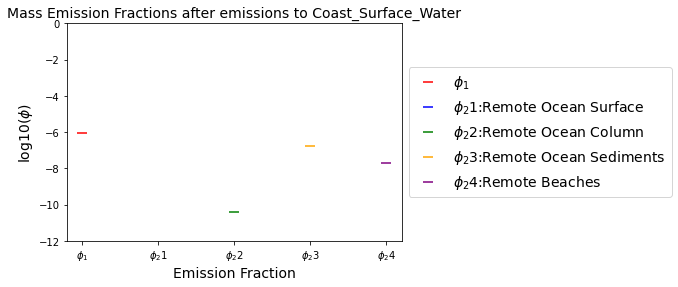

Overall mass persistence (years): 197
Overall particle number persistence (years): 199
Overall persistence of size 0.5 um (years): 199
Overall persistence of size 5.0 um (years): 199
Overall persistence of size 50.0 um (years): 195
Overall persistence of size 500.0 um (years): 179
Overall persistence of size 5000.0 um (years): 99
Overall residence time is calculated assuming the model boundaries to be at 100 m depth into the Ocean, 30 cm into the sediments and 0.1 m into the soil. Particles travelling deeper are considered losses
Overall mass residence time (years): 27.2
Overall particle number residence time (years): 26.1
Overall residence time of size 0.5 um (years): 26.1
Overall residence time of size 5.0 um (years): 26.32
Overall residence time of size 50.0 um (years): 27.24
Overall residence time of size 500.0 um (years): 26.96
Overall residence time of size 5000.0 um (years): 24.04
Characteristic mass travel distance (CDT):  2270.8  km
Characteristic particle number travel distan

In [49]:
# For estimating exposure indicators we need to make emissions to targeted compartments.

# Run model with emissions to specific compartments to estimate the emission fractions
from functions.model_run_by_comp import *

model_results = {}
dispersing_comp_list = [
    "Air",
    "Ocean_Mixed_Water",
    "Ocean_Surface_Water",
]

for dispersing_comp in dispersing_comp_list:
    model_results[dispersing_comp] = run_model_comp(
        dispersing_comp,
        input_flow_g_s,
        interactions_df,
        MP_form,
        size_bin,
        particle_forms_coding,
        particle_compartmentCoding,
        system_particle_object_list,
        comp_dict_inverse,
        dict_comp,
        size_dict,
        MP_form_dict_reverse,
        surfComp_list,
    )


# # Run model with emissions to specific compartments of the targeted size bin to estimate the particle number dispersion fractions
# model_results_size_bin = {}
# for size in size_dict:
#     model_results_size_bin[size] = {}
#     for dispersing_comp in dispersing_comp_list:
#         model_results_size_bin[size][dispersing_comp] = run_model_comp(
#             dispersing_comp,
#             input_flow_g_s,
#             interactions_df,
#             MP_form,
#             size_bin=size,
#             particle_forms_coding=particle_forms_coding,
#             particle_compartmentCoding=particle_compartmentCoding,
#             system_particle_object_list=system_particle_object_list,
#             comp_dict_inverse=comp_dict_inverse,
#             dict_comp=dict_comp,
#             size_dict=size_dict,
#             MP_form_dict_reverse=MP_form_dict_reverse,
#             surfComp_list=surfComp_list,
#         )


#### EXPOSURE INDICATORS ####
from functions.emission_fractions_calculation import *


# Estimate emission fractions for the setted emission scenario

emission_fractions_mass_data = emission_fractions_calculations(
    Results_extended,
    model_results,
    dispersing_comp_list,
    dict_comp,
    input_flow_g_s,
    q_num_s,
    size_dict,
    emiss_comp,
)


plot_emission_fractions(emission_fractions_mass_data, emiss_comp)


# Overall persistance (Pov) and Overall residence time (Tov) in years:

(
    Pov_mass_years,
    Pov_num_years,
    Pov_size_dict_sec,
    Tov_mass_years,
    Tov_num_years,
    Tov_size_dict_sec,
) = Exposure_indicators_calculation(
    tables_outputFlows,
    tables_outputFlows_number,
    Results_extended,
    size_dict,
    dict_comp,
    system_particle_object_list,
)

# Caracteristic travel distance (CDT) (m):

# To calculate CTD we need to estimate it by emitting into the especific mobile compartment. We will calculate CTD derived from emmiting to each compartment and taking the higest value:
CTD_mass_list = []
CTD_number_list = []


for CDT_comp in [
    "Ocean_Surface_Water",
    "Ocean_Mixed_Water",
    "Coast_Surface_Water",
    "Coast_Column_Water",
    "Surface_Freshwater",
    "Bulk_Freshwater",
    "Air",
]:
    # input flow (in g per second) for each compartment the User should specify here the input flows per compartment
    q_mass_g_s_dict_CTD = {
        "Ocean_Surface_Water": 0,
        "Ocean_Mixed_Water": 0,
        "Ocean_Column_Water": 0,
        "Coast_Surface_Water": 0,
        "Coast_Column_Water": 0,
        "Surface_Freshwater": 0,
        "Bulk_Freshwater": 0,
        "Sediment_Freshwater": 0,
        "Sediment_Ocean": 0,
        "Sediment_Coast": 0,
        "Urban_Soil_Surface": 0,
        "Urban_Soil": 0,
        "Background_Soil_Surface": 0,
        "Background_Soil": 0,
        "Agricultural_Soil_Surface": 0,
        "Agricultural_Soil": 0,
        "Air": 0,
    }
    q_mass_g_s_dict_CTD[CDT_comp] = input_flow_g_s

    sp_imputs_CTD = []
    q_mass_g_s_CTD = []
    for compartment in q_mass_g_s_dict_CTD.keys():
        sp_imputs_CTD.append(
            size_bin
            + particle_forms_coding[MP_form]
            + str(particle_compartmentCoding[compartment])
            + "_"
            + boxName
        )
        q_mass_g_s_CTD.append(q_mass_g_s_dict_CTD[compartment])

    imput_flows_g_s_CTD = dict(zip(sp_imputs_CTD, q_mass_g_s_CTD))

    CTD_km = model_run_CTD(
        system_particle_object_list,
        CDT_comp,
        imput_flows_g_s_CTD,
        interactions_df,
        q_mass_g_s_CTD,
        size_dict,
        MP_form_dict_reverse,
        comp_dict_inverse,
        dict_comp,
    )

    CTD_mass_list.append(CTD_km[0])
    CTD_number_list.append(CTD_km[1])

CTD_df = pd.DataFrame(
    index=[
        "Ocean_Surface_Water",
        "Ocean_Mixed_Water",
        "Coast_Surface_Water",
        "Coast_Column_Water",
        "Surface_Freshwater",
        "Bulk_Freshwater",
        "Air",
    ]
)

CTD_df["CTD_mass_km"] = CTD_mass_list
CTD_df["CTD_particle_number_km"] = CTD_number_list

print(
    "Characteristic mass travel distance (CDT): ",
    round(CTD_df["CTD_mass_km"].max(), 1),
    " km",
)

print(
    "Characteristic particle number travel distance (CDT): ",
    round(CTD_df["CTD_particle_number_km"].max(), 1),
    " km",
)
